In [3]:
import pandas as pd
import numpy as np
import warnings

# Suppress all runtime warnings (e.g., divide by zero, overflow)
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all='ignore')

cars_LinearRegression = pd.read_parquet("cars_ready_LinearRegression_small.parquet")
print("Price" in cars_LinearRegression.columns)
print(cars_LinearRegression.columns.tolist())


cars_DecisionTree = pd.read_parquet("cars_ready_DecisionTree_small.parquet")
print("Price" in cars_DecisionTree.columns)
print(cars_DecisionTree.columns.tolist())


cars_BART = pd.read_parquet("cars_ready_BART.parquet")
print("Price" in cars_BART.columns)
print(cars_BART.columns.tolist())

False
['Mileage', 'Log_Mileage', 'Age', 'Log_Age', 'Mileage_per_Year', 'Engine_Power', 'Engine_Capacity', 'Power_per_Liter', 'No_Accidents', 'Service_Record', 'Is_Imported', 'First_Owner', 'Professional_Seller', 'Make_Aixam', 'Make_Alfa Romeo', 'Make_Audi', 'Make_Baic', 'Make_Bentley', 'Make_Bmw', 'Make_Cadillac', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Citroën', 'Make_Cupra', 'Make_Dacia', 'Make_Daihatsu', 'Make_Dodge', 'Make_Ds Automobiles', 'Make_Fiat', 'Make_Ford', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti', 'Make_Isuzu', 'Make_Iveco', 'Make_Jaecoo', 'Make_Jaguar', 'Make_Jeep', 'Make_Kia', 'Make_Lamborghini', 'Make_Lancia', 'Make_Land Rover', 'Make_Lexus', 'Make_Maserati', 'Make_Mazda', 'Make_Mercedes-Benz', 'Make_Mg', 'Make_Mini', 'Make_Mitsubishi', 'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche', 'Make_Ram', 'Make_Renault', 'Make_Saab', 'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong/Kgm', 'Make_Subaru', 'Make_Suzuki', 'Make_Tesla', 'Make_Toyota', 'Make_Vo

In [4]:
# --- Importy ---
import pandas as pd
import numpy as np
import torch
from joblib import Parallel, delayed
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

# --- Ustawienia ---
warnings.filterwarnings("ignore")
np.seterr(all='ignore')
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
# --- Dane ---
cars_DecisionTree = pd.read_parquet("cars_ready_DecisionTree_small.parquet")
train_df = cars_DecisionTree[cars_DecisionTree["cv_fold"] != -1].dropna()
test_df = cars_DecisionTree[cars_DecisionTree["cv_fold"] == -1].dropna()

X_train = train_df.drop(columns=["Log_Price", "cv_fold", "split"]).astype(np.float32).values
y_train = train_df["Log_Price"].astype(np.float32).values

X_test = test_df.drop(columns=["Log_Price", "cv_fold", "split"]).astype(np.float32).values
y_test = test_df["Log_Price"].astype(np.float32).values

print(f"✅ Final TabNet input shape: {X_train.shape}")

# --- Funkcja treningowa dla pojedynczego folda ---
def train_fold_tabnet(fold, train_idx, val_idx):
    X_tr, y_tr = X_train[train_idx], y_train[train_idx]
    X_val, y_val = X_train[val_idx], y_train[val_idx]

    model = TabNetRegressor(
        n_d=64, n_a=64,
        n_steps=5,
        gamma=1.5,
        n_independent=2,
        n_shared=2,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        mask_type='entmax',
        verbose=0,
        seed=42 + fold,
        device_name=DEVICE
    )

    model.fit(
        X_tr, y_tr.reshape(-1, 1),
        eval_set=[(X_val, y_val.reshape(-1, 1))],
        eval_metric=['mae'],
        patience=10,
        max_epochs=100,
        batch_size=1024,
        virtual_batch_size=128
    )

    preds_val = model.predict(X_val).flatten()
    return (
        mean_absolute_error(y_val, preds_val),
        np.sqrt(mean_squared_error(y_val, preds_val)),
        r2_score(y_val, preds_val)
    )

# --- Cross-validation równolegle ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
splits = list(kf.split(X_train))

results = Parallel(n_jobs=1)(
    delayed(train_fold_tabnet)(i, train_idx, val_idx)
    for i, (train_idx, val_idx) in enumerate(splits)
)

# --- Podsumowanie wyników CV ---
mae_cv, rmse_cv, r2_cv = zip(*results)

print("\n📊 TabNet Cross-validation Results (parallel):")
print(f"MAE_CV   = {np.mean(mae_cv):.4f}")
print(f"RMSE_CV  = {np.mean(rmse_cv):.4f}")
print(f"R²_CV    = {np.mean(r2_cv):.4f}")

✅ Final TabNet input shape: (165236, 119)

Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mae = 0.14714

Early stopping occurred at epoch 74 with best_epoch = 64 and best_val_0_mae = 0.1399

Early stopping occurred at epoch 54 with best_epoch = 44 and best_val_0_mae = 0.15533

Early stopping occurred at epoch 43 with best_epoch = 33 and best_val_0_mae = 0.14209

Early stopping occurred at epoch 25 with best_epoch = 15 and best_val_0_mae = 0.16213

📊 TabNet Cross-validation Results (parallel):
MAE_CV   = 0.1493
RMSE_CV  = 0.2152
R²_CV    = 0.9462


In [5]:
# --- Final training on all train set ---
final_model = TabNetRegressor(
    n_d=64, n_a=64,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    verbose=0,
    seed=999,
    device_name=DEVICE
)

final_model.fit(
    X_train, y_train.reshape(-1, 1),
    max_epochs=100,
    batch_size=1024,
    virtual_batch_size=128,
    patience=10
)

# --- Predict on test set ---
y_pred_test = final_model.predict(X_test).flatten()

# --- Test performance summary ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("\n📊 TabNet Test Set Performance:")
print(f"MAE_Test  = {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"RMSE_Test = {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")
print(f"R²_Test   = {r2_score(y_test, y_pred_test):.4f}")


📊 TabNet Test Set Performance:
MAE_Test  = 0.1481
RMSE_Test = 0.2136
R²_Test   = 0.9469


In [7]:
from tabulate import tabulate
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# --- Zbuduj DataFrame z wynikami TabNet ---
tabnet_results = pd.DataFrame({
    "MAE_CV": [np.mean(mae_cv)],
    "RMSE_CV": [np.mean(rmse_cv)],
    "R2_CV": [np.mean(r2_cv)],
    "MAE_Test": [mae_test],
    "RMSE_Test": [rmse_test],
    "R2_Test": [r2_test]
}, index=["TabNet"]).round(4)

# --- Wyświetl tabelę ---
print("\n📊 TabNet Cross-validation and test set performance:")
print(tabulate(tabnet_results, headers='keys', tablefmt='github'))


📊 TabNet Cross-validation and test set performance:
|        |   MAE_CV |   RMSE_CV |   R2_CV |   MAE_Test |   RMSE_Test |   R2_Test |
|--------|----------|-----------|---------|------------|-------------|-----------|
| TabNet |   0.1493 |    0.2152 |  0.9462 |     0.1481 |      0.2136 |    0.9469 |


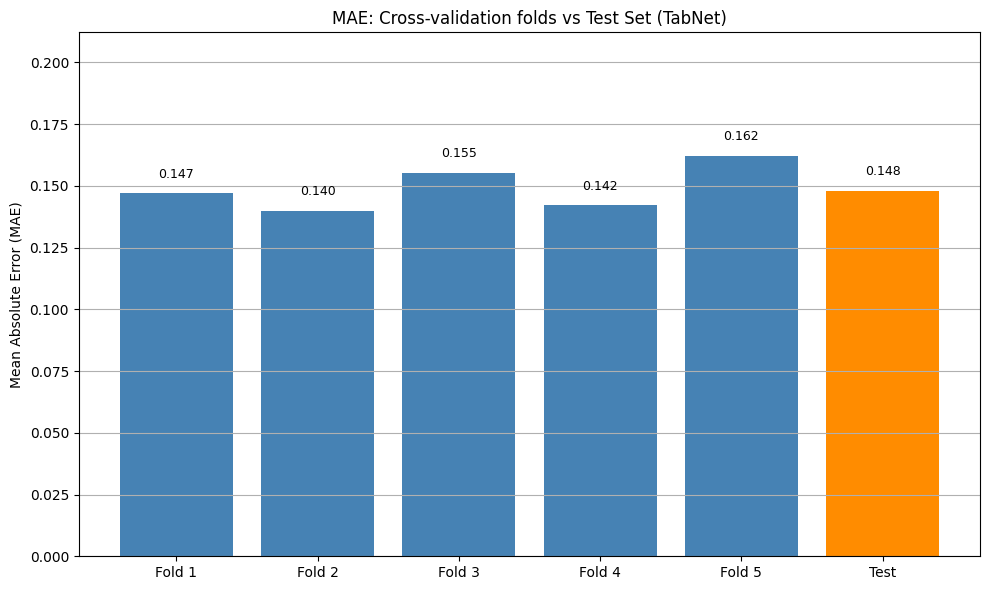

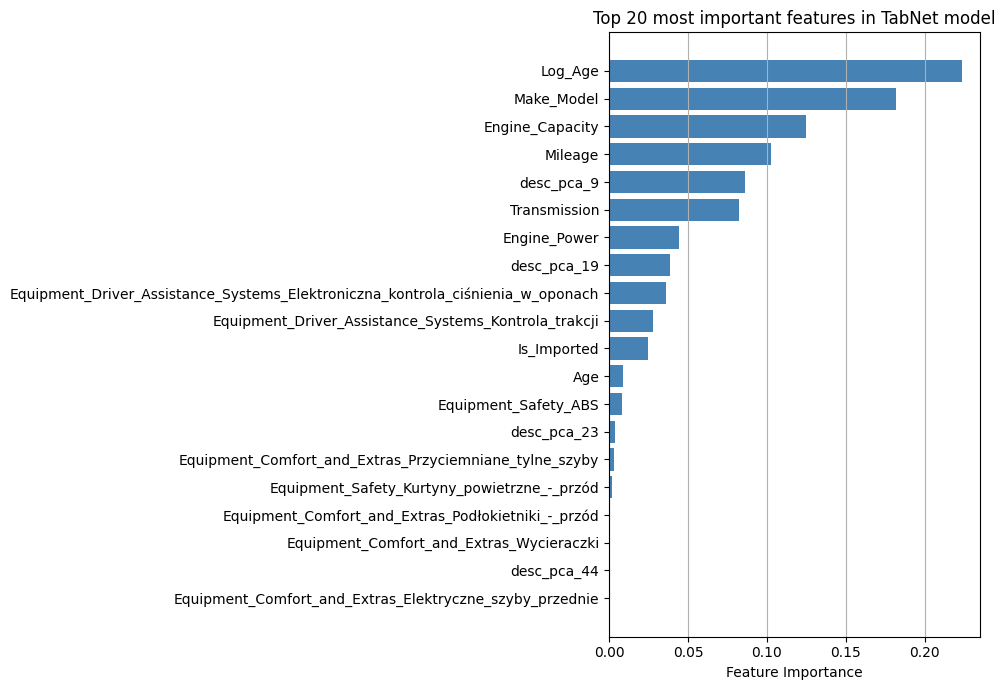

In [6]:
# --- Wykres MAE: Cross-validation vs Test ---
import matplotlib.pyplot as plt

# MAE Test
mae_test = mean_absolute_error(y_test, y_pred_test)

# MAE per fold + test
plt.figure(figsize=(10, 6))
bars = plt.bar([f"Fold {i+1}" for i in range(len(mae_cv))] + ["Test"], list(mae_cv) + [mae_test],
               color=["steelblue"] * len(mae_cv) + ["darkorange"])
plt.title("MAE: Cross-validation folds vs Test Set (TabNet)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.ylim(0, max(mae_cv + (mae_test,)) + 0.05)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=9)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- Wykres ważności cech z TabNet ---
feature_importances = final_model.feature_importances_
feature_names = train_df.drop(columns=["Log_Price", "cv_fold", "split"]).columns.tolist()

# Najważniejsze 20 cech
top_n = 20
top_indices = np.argsort(feature_importances)[-top_n:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_scores = feature_importances[top_indices]

plt.figure(figsize=(10, 7))
plt.barh(top_features[::-1], top_scores[::-1], color="steelblue")
plt.title("Top 20 most important features in TabNet model")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()